In [104]:
from colmap_testing.colmap_helpers import read_write_model
import os
import cv2
import numpy as np
from constants import *
from matplotlib import pyplot as plt

#https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [105]:
recording_id = "ff0acdab-123d-41d8-bfd6-b641f99fc8eb"
colmap_ws_path = os.path.join(recordings_folder, recording_id, "colmap_ws")
colmap_dataset_path = os.path.join(colmap_ws_path, "dataset")
colmap_output_path = os.path.join(colmap_ws_path, "colmap_out_1")

#path_to_world_images = os.path.join(colmap_output_path,"dense", "images", "world_images_distorted")
path_to_world_images = os.path.join(colmap_dataset_path, "images", "all_images") #FIXME TEMPORARY
#path_to_depth_rgb_images = os.path.join(colmap_output_path,"dense", "images", "depth_images")
path_to_depth_rgb_images = os.path.join(colmap_dataset_path, "images", "all_images") #FIXME TEMPORARY

world_images = sorted_alphanumeric(os.listdir(path_to_world_images))
#remove last image (which is the depth image)
world_images = world_images[:-1]
depth_images = sorted_alphanumeric(os.listdir(path_to_depth_rgb_images))
#only keep last image (which is the depth image)
depth_images = depth_images[-1:]

path_to_model = os.path.join('/scratch_net/snapo/mlindner/docs/gaze_data_acquisition/mathis/recordings/ff0acdab-123d-41d8-bfd6-b641f99fc8eb/colmap_ws/colmap_out_1/sparse')                        #FIXME TEMPORARY
world_image_paths = [os.path.join(path_to_world_images, str(name)) for name in world_images]
depth_image_paths = [os.path.join(path_to_depth_rgb_images, str(name)) for name in depth_images]
#all_image_paths = [os.path.join(path_to_world_images, str(name)) for name in world_images]


In [106]:
world_images_array = np.array([np.array(cv2.imread(imagepath)) for imagepath in world_image_paths])
depth_images_array = np.array([np.array(cv2.imread(imagepath)) for imagepath in depth_image_paths])
#all_images_array = np.array([np.array(cv2.imread(imagepath)) for imagepath in all_image_paths])

colmap_model = read_write_model.read_model(path_to_model, ".bin")

#cameras:fx, fy, cx, cy, width, height
#images:camera_id, qvec, tvec, name 
#points:xyz, rgb, error, image_ids, point2D_idxs
cameras, images, points = read_write_model.read_model(path_to_model, ".bin")

# 3D point list with one line of data per point:
# POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
points_keys = list(points.keys())

image_ids_visible_point = []
while 79 not in image_ids_visible_point or len(image_ids_visible_point) < 6 or len(image_ids_visible_point) > 10:
    random_key = np.random.choice(points_keys)
    random_point = points[random_key]
    random_point_3d = random_point.xyz
    z = random_point_3d[2]
    image_ids_visible_point = random_point.image_ids

print(image_ids_visible_point)

# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)

#first_image = images[1]

# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
#first_camera = cameras[1]



#The coordinates of the projection/camera center are given by -R^t * T, 
# where R^t is the inverse/transpose of the 3x3 rotation matrix composed from the quaternion and T is the translation vector. 
# The local camera coordinate system of an image is defined in a way that the X axis points to the right, 
# the Y axis to the bottom, and the Z axis to the front as seen from the image.

#calculate the projection/camera center

8.119844018053612
5.430170728278311
2.4376284172057088
7.799841883013088
7.521605811316199
9.02850911538589
8.366253931895884
15.895334778945626
16.243627916849928
8.40764343710365
6.44495104095563
10.636155353201202
9.184880369247653
9.596001338174359
4.896153874025628
15.99952376534336
9.740346184984736
8.46941481381699
2.9763749090573444
4.351906172629969
10.143584060442803
6.016937621748858
4.083772446255398
9.595424256984467
7.508575398061272
8.471860545449195
11.315485056355687
7.672336106473381
1.5710030866844957
4.251182457441919
2.5180711941292397
8.340353667622612
8.705192015028368
5.1703793093579025
15.851631195597422
15.712931099447166
5.593584150545592
7.484140496546439
9.450559405877224
6.084391296880568
8.04939786895657
6.254714931540728
9.689463747462893
8.504647206874106
6.215818867629823
10.916453511637307
9.842112779595011
4.2640152349902944
15.587671597105864
5.199702339481957
11.673501291944351
16.169945956875758
11.909960002500908
3.525835689470704
9.9084359026047

In [111]:
images[79]

Image(id=79, qvec=array([ 0.94372684, -0.22389152,  0.24316151,  0.01116795]), tvec=array([-1.30545864, -2.2993128 ,  0.22481773]), camera_id=79, name='depth_rgb.png', xys=array([[160.47160339,   5.92344856],
       [ 19.82156181,   6.81700659],
       [ 39.55140305,  12.87485409],
       ...,
       [513.75616455, 113.48010254],
       [513.75616455, 113.48010254],
       [610.0425415 , 179.51731873]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

In [107]:
def get_frames(images, cameras, scale=1):
    frames = []
    keys = images.keys()
    
    for key in keys:
        img = images[key]
        # rotation
        R = read_write_model.qvec2rotmat(img.qvec)

        # translation
        t = img.tvec

        # invert
        t = -R.T @ t
        R = R.T

        # intrinsics
        cam = cameras[img.camera_id]
        print(cam)
        if cam.model in ("SIMPLE_PINHOLE", "SIMPLE_RADIAL", "RADIAL"):
            fx = fy = cam.params[0]
            cx = cam.params[1]
            cy = cam.params[2]
        elif cam.model in ("PINHOLE", "OPENCV", "OPENCV_FISHEYE", "FULL_OPENCV"):
            fx = cam.params[0]
            fy = cam.params[1]
            cx = cam.params[2]
            cy = cam.params[3]
            if cam.id == 2 and 0==1:
                fx = 388.0116271972656
                fy = 388.0116271972656
                cx = 321.6023254394531
                cy = 241.12362670898438
        else:
            raise Exception("Camera model not supported")

        # intrinsics
        K = np.identity(3)
        K[0, 0] = fx
        K[1, 1] = fy
        K[0, 2] = cx
        K[1, 2] = cy
        frames.append((key, R, t, K))
    return frames

Camera(id=49, model='PINHOLE', width=1088, height=1080, params=array([772.79182842, 769.56462004, 553.5783632 , 543.5611312 ]))
Camera(id=77, model='PINHOLE', width=1088, height=1080, params=array([770.21944674, 773.80175167, 553.5783632 , 543.5611312 ]))
Camera(id=54, model='PINHOLE', width=1088, height=1080, params=array([772.12199682, 769.01429677, 553.5783632 , 543.5611312 ]))
Camera(id=68, model='PINHOLE', width=1088, height=1080, params=array([771.34184627, 764.76835791, 553.5783632 , 543.5611312 ]))
Camera(id=62, model='PINHOLE', width=1088, height=1080, params=array([771.38667977, 771.00483335, 553.5783632 , 543.5611312 ]))
Camera(id=65, model='PINHOLE', width=1088, height=1080, params=array([772.57088511, 771.22627999, 553.5783632 , 543.5611312 ]))
Camera(id=53, model='PINHOLE', width=1088, height=1080, params=array([770.9902343 , 771.18970421, 553.5783632 , 543.5611312 ]))
Camera(id=50, model='PINHOLE', width=1088, height=1080, params=array([772.55366265, 769.75510504, 553.57

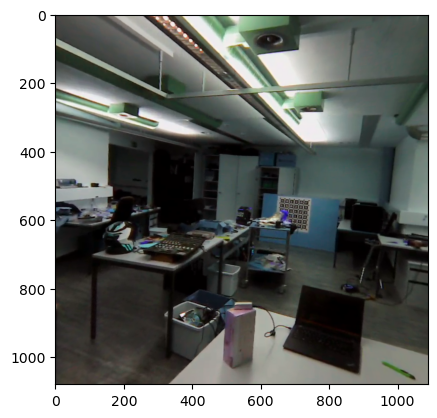

(1883.050215085657, 793.2277723789869)


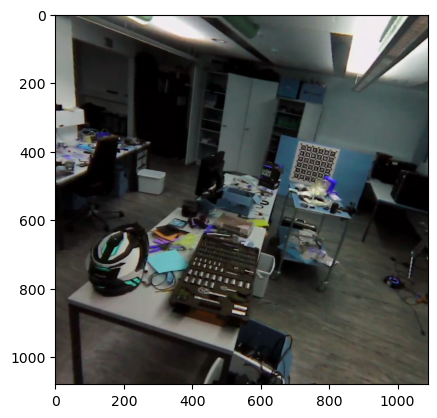

(2921.5527914759273, 1415.9189734824843)


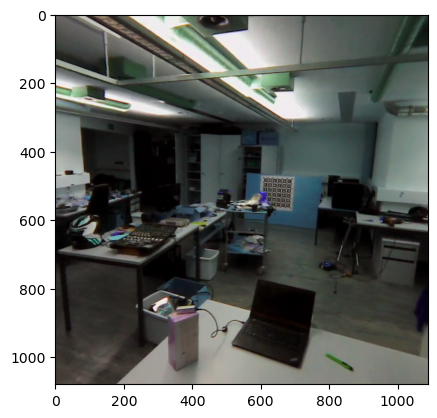

(2008.5360944767647, 833.8820846896508)


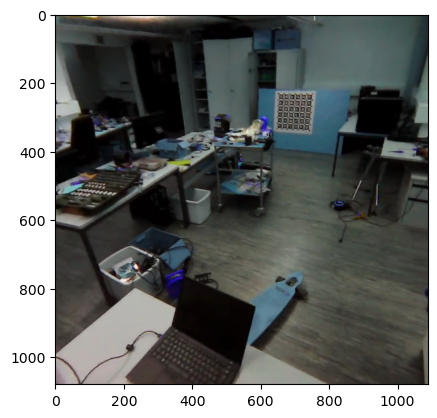

(2460.357692922172, 1236.411881658612)


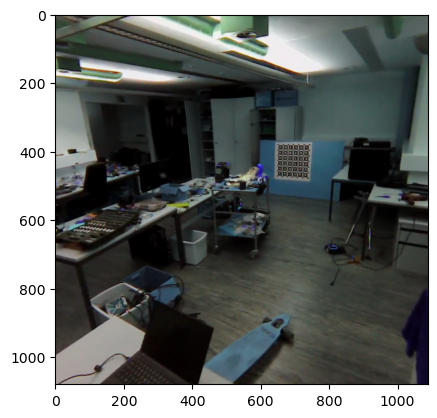

(2705.824111512067, 1271.6558161875523)


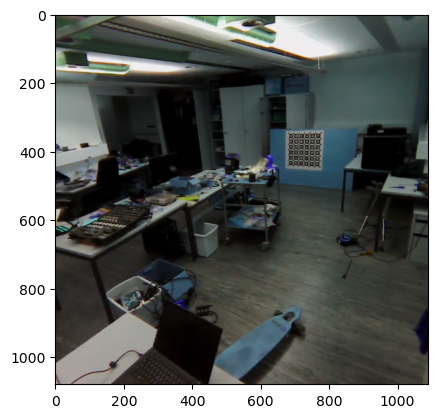

(3337.695949079508, 1635.8243039902445)


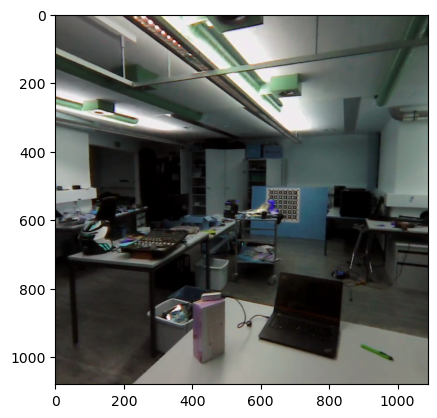

(3980.1321307518883, 1583.3579239768112)


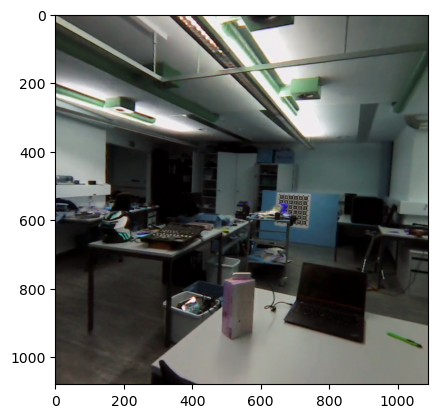

(3227.171849842262, 1093.8967858870662)


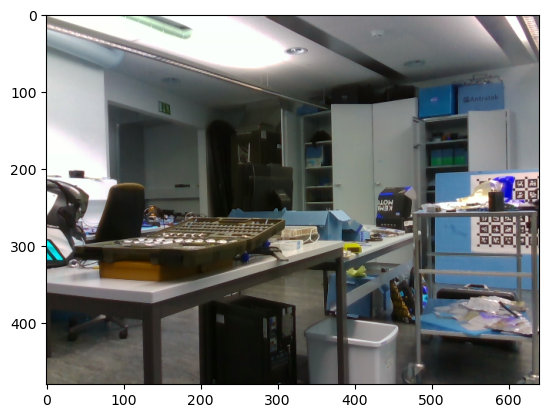

In [108]:
visible_images = dict((image_id, images[image_id]) for image_id in random_point.image_ids)
frames = get_frames(visible_images, cameras)
if not os.path.exists(os.path.join(colmap_ws_path,"reprojections_test")):
    os.mkdir(os.path.join(colmap_ws_path,"reprojections_test"))
for frame in frames:
    image_id, R, t, K = frame
    if image_id == 1:
        image_name = os.path.join("depth_camera",visible_images[image_id].name)
    else:
        image_name = os.path.join("world_camera_undistorted",visible_images[image_id].name)
    image_name = visible_images[image_id].name
    path_to_image = os.path.join(colmap_dataset_path,"images", "all_images", image_name)
    image_array = cv2.imread(path_to_image)
    #add nested to t
    t = np.array([t]).T
    P = K @ np.hstack((R, t)) #projection matrix
    point_on_image = P @ np.hstack((random_point_3d, 1))
    point_on_image = point_on_image / point_on_image[2]
    image_dimensions = image_array.shape
    converted_to_image_coordinates = image_dimensions[1] - point_on_image[0], image_dimensions[0] - point_on_image[1]
    print(converted_to_image_coordinates)
    plt.scatter(converted_to_image_coordinates[0], converted_to_image_coordinates[1], c="r")
    plt.imshow(image_array)
    #plt.savefig(os.path.join(colmap_ws_path, "reprojections_test", str(image_id) + ".png"))
    plt.show()
    plt.close()